## Data Loading

In [1]:
import h5py
import torch

path = "/home/cmu/anthony/MP-Neural-PDE-Solvers/data/CE_train_E1.h5"
f = h5py.File(path, 'r')
data = f['train']
data.keys()

<KeysViewHDF5 ['alpha', 'beta', 'gamma', 'pde_250-100', 'pde_250-200', 'pde_250-40', 'pde_250-50']>

In [2]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
train_loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=False,
                        num_workers=4)
u_base, u_super, x, variables = next(iter(train_loader))
batch_size, tn, xn = u_base.shape

In [3]:
u_base[0][0][0:10]

tensor([0.4675, 0.5472, 0.6220, 0.6911, 0.7534, 0.8082, 0.8545, 0.8919, 0.9197,
        0.9376])

In [5]:
u_super[0][0][0:10]

tensor([0.4666, 0.5456, 0.6199, 0.6885, 0.7504, 0.8048, 0.8510, 0.8883, 0.9163,
        0.9345])

100%|██████████| 250/250 [00:00<00:00, 958.26it/s]


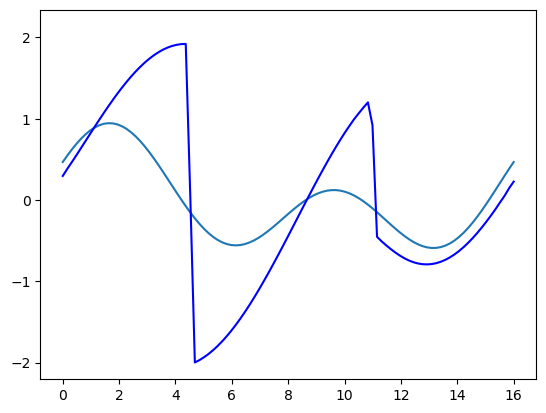

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

u_n = u_base[0]
x_n = x[0]

fig, ax = plt.subplots()

# Store the plot handle at each time step in the 'ims' list
ims = []
for i in tqdm(range(tn)):
    im = ax.plot(x_n, u_n[i],'b-', animated=True)
    if i == 0:
        ax.plot(x_n, u_n[i].squeeze())  # show an initial one first
    ax.plot
    ims.append([im[0]])

# Animate the plot
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save("assets/movie_E1_5_1.gif", writer=writer)

## GPT Setup

In [50]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
train_loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=4)

config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model = GPT(config)
u_base, u_super, x, variables = next(iter(train_loader))
out = model(u_base[:, :250, :])

number of parameters: 2.48M


In [51]:
out2 = model(u_base[:, :100, :])

In [54]:
torch.allclose(out[:, :100, :], out2[:, :100, :])

True

## GNN Setup

In [1]:
from common.utils import HDF5Dataset
from torch.utils.data import DataLoader
from experiments.models_gpt import GPT
from common.utils import GraphCreator
from equations.PDEs import *
import random
from experiments.models_gnn import MP_PDE_Solver

pde = 'CE'
experiment = 'E1'
train_string = f'data/{pde}_train_{experiment}.h5'
dataset = HDF5Dataset(train_string, pde=pde, mode='train')
loader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=4)

u_base, u_super, x, variables = next(iter(loader))

base_resolution = (250, 100)
pde = CE()
pde.tmin = dataset.tmin
pde.tmax = dataset.tmax
pde.grid_size = base_resolution
pde.dt = dataset.dt
graph_creator = GraphCreator(pde=pde,
                            neighbors=2,
                            time_window=20,
                            t_resolution=base_resolution[0],
                            x_resolution=base_resolution[1])

unrolling = [r for r in range(2 + 1)]
unrolled_graphs = random.choice(unrolling)
steps = [t for t in range(graph_creator.tw,
                            graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
random_steps = random.choices(steps, k=2)
data, labels = graph_creator.create_data(u_super, random_steps)
data_gpt = u_super

config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model_gpt = GPT(config)
embeddings = model_gpt(data_gpt)
graph = graph_creator.create_graph(data, embeddings, labels, x, variables, random_steps)

eq_variables = {}
model = MP_PDE_Solver(pde=pde,
                        time_window=graph_creator.tw,
                        eq_variables=eq_variables)

pred = model(graph)

number of parameters: 2.48M


In [2]:
graph.x.shape

torch.Size([200, 20])

In [3]:
pred.shape

torch.Size([200, 20])

In [8]:
u = data.x
e = data.e
# Encode and normalize coordinate information
pos = data.pos
pos_x = pos[:, 1][:, None] / pde.L
pos_t = pos[:, 0][:, None] / pde.tmax
edge_index = data.edge_index
batch = data.batch

variables = pos_t    # time is treated as equation variable

# Encoder and processor (message passing)
node_input = torch.cat((u, e, pos_x, variables), -1)

In [14]:
node_input.shape

torch.Size([200, 12])

In [6]:
data.alpha

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [3]:
graph.e.shape

torch.Size([200, 5])

In [91]:
graph = graph_creator.create_graph(data, labels, x, variables, random_steps)

In [108]:
config = {"batch_size" : 2, # if gradient_accumulation_steps > 1, this is the micro-batch size
        "n_x": 100, 
        "block_size" : 250, # max sequence length for predicting next timestep. Sequence length can be shorter.
        "n_layer" : 3, 
        "n_head" : 8,
        "n_embd" : 256,
        "n_gnn": 100,
        "dropout" : 0.0, # for pretraining 0 is good, for finetuning try 0.1+
        "bias" : False # do we use bias inside LayerNorm and Linear layers?
}

model_gpt = GPT(config)

number of parameters: 2.48M


In [109]:
embeddings = model_gpt(data_gpt)

In [121]:
embeddings[0][0:5].shape

torch.Size([5, 100])

In [122]:
nt = pde.grid_size[0]
nx = pde.grid_size[1]
t = torch.linspace(pde.tmin, pde.tmax, nt)
tw = 5

u, e, x_pos, t_pos, y, batch = torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()
for b, (data_batch, e_batch, labels_batch, step) in enumerate(zip(data, embeddings, labels, steps)):
    # data_batch is [nt, nx]


    e_time = e_batch[step - tw:step]
    u = torch.cat((u, torch.transpose(torch.cat([d[None, :] for d in data_batch]), 0, 1)), )
    e = torch.cat((e, torch.transpose(torch.cat([e_t[None, :] for e_t in e_time]), 0, 1)), )
    y = torch.cat((y, torch.transpose(torch.cat([l[None, :] for l in labels_batch]), 0, 1)), )
    x_pos = torch.cat((x_pos, x[0]), )
    t_pos = torch.cat((t_pos, torch.ones(nx) * t[step]), )
    batch = torch.cat((batch, torch.ones(nx) * b), )

In [123]:
e.shape

torch.Size([200, 5])

In [124]:
u.shape

torch.Size([200, 5])

In [125]:
test3 = torch.cat((u, e), dim=1)

In [126]:
test3.shape

torch.Size([200, 10])

In [111]:
data_batch = data[0]
test = [d[None, :] for d in data_batch]

In [118]:
test2 = torch.cat(test)

In [119]:
test2.shape

torch.Size([5, 100])

In [117]:
len(test)

5

In [17]:
(out).shape

torch.Size([2, 250, 100])